# Classification de chiffres manuscrits – KNN et PCA

Ce notebook présente une étude du jeu de données Digits avec une approche structurée intégrant une approche KNN + PCA afin de la comparer avec la même approche mais sans PCA. Ce jeu de données est composé d'image noir et blanc de chiffre de 0 à 9 et provient de la librairie sklearn

## Librairies

In [29]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
import time

## Réduction de dimension par PCA

## 1. Setup

L'analyse du dataset ayant déjà été faite dans le notebook sans PCA je ne le refais pas ici.

In [30]:
digits = load_digits()
X = digits.data
y = digits.target
# Afficher le nombre d'entrée et la forme de ces entrées
print(f"Nombre d'élément : {X.shape[0]} | Nombre de feature : {X.shape[1]}")

Nombre d'élément : 1797 | Nombre de feature : 64


In [31]:
# Comptage des exemples par classe
classes, counts = np.unique(y, return_counts=True)

In [32]:
# 60 % train, 20 % test, 20 % validation
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# affichage de la taille de chaque base découpée
print("Train :", X_train.shape[0])
print("Test (hyperparamètres) :", X_test.shape[0])
print("Validation finale :", X_val.shape[0])


Train : 1078
Test (hyperparamètres) : 359
Validation finale : 360


## 2. Analyse du PCA sur le dataset

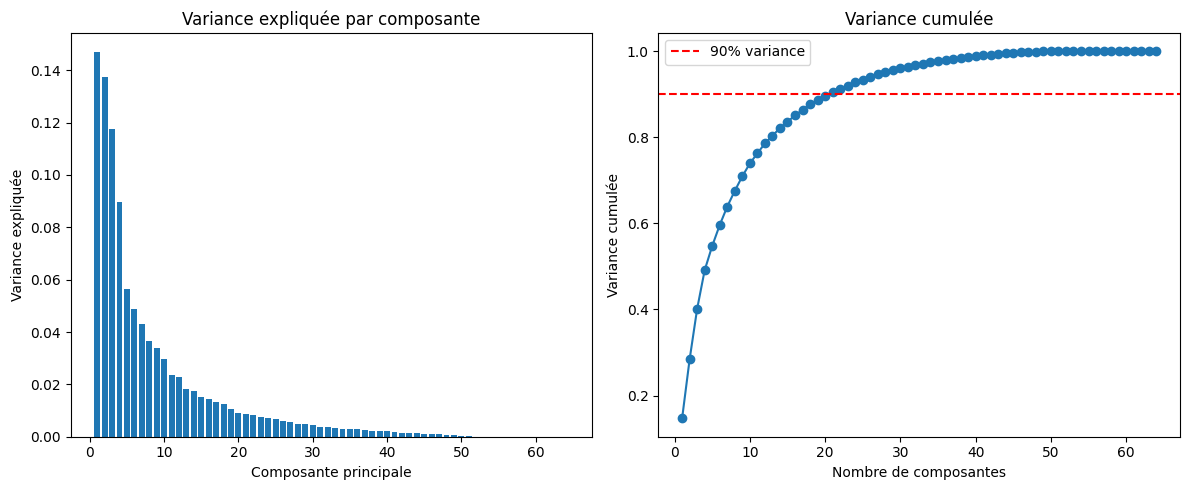

In [33]:
# PCA complet sur X_train pour analyse
pca_full = PCA()
pca_full.fit(X_train)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12,5))

# 1. Variance expliquée par composante
plt.subplot(1,2,1)
plt.bar(range(1,len(explained_variance)+1), explained_variance)
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée")
plt.title("Variance expliquée par composante")

# 2. Variance cumulée
plt.subplot(1,2,2)
plt.plot(range(1,len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% variance')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance cumulée")
plt.title("Variance cumulée")
plt.legend()
plt.tight_layout()
plt.show()

Test sur une image pour avoir une idée de l'erreur lié à la reconstitution de l'image de 1 à 64 de composantes

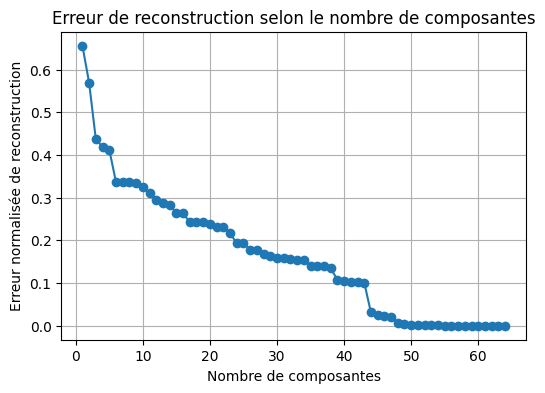

In [34]:
# On prend une image de test pour étudier la reconstruction et l'erreur associée
index = 9
original = X_test[index]

errors = []

for M in range(1, X_train.shape[1]+1):
    pca_temp = PCA(n_components=M)
    X_train_pca_temp = pca_temp.fit_transform(X_train)
    image_reconstructed = pca_temp.inverse_transform(pca_temp.transform(original.reshape(1, -1)))
    error = np.linalg.norm(original - image_reconstructed) / np.linalg.norm(original)
    errors.append(error)

plt.figure(figsize=(6,4))
plt.plot(range(1, X_train.shape[1]+1), errors, marker='o')
plt.xlabel("Nombre de composantes")
plt.ylabel("Erreur normalisée de reconstruction")
plt.title("Erreur de reconstruction selon le nombre de composantes")
plt.grid(True)
plt.show()


J'ai choisi de conserver 90% de variance cumulé. Cela donne d'après le graphe un nombre de composante M = 20.

Visualisation de la réduction de dimension sur une image

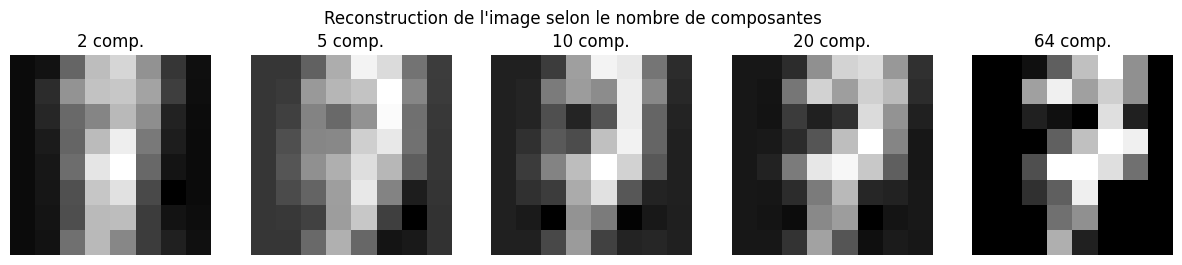

In [35]:
# Vizualisation sur une image pour différents niveaux de composantes
composantes_list = [2, 5, 10, 20, M]  # différents niveaux
plt.figure(figsize=(15,3))

for i, M_i in enumerate(composantes_list):
    pca_temp = PCA(n_components=M_i)
    pca_temp.fit(X_train)
    image_reconstructed = pca_temp.inverse_transform(pca_temp.transform(original.reshape(1, -1)))
    
    plt.subplot(1,len(composantes_list), i+1)
    plt.imshow(image_reconstructed.reshape(8,8), cmap='gray')
    plt.title(f"{M_i} comp.")
    plt.axis('off')

plt.suptitle("Reconstruction de l'image selon le nombre de composantes")
plt.show()


Remarque : On distingue bien la forme final du chiffre à 20 composantes sur cet exemple.

## Test du knn sur M composante
Même logique que le knn sans PCA mais cette fois on utilise la dimension réduite que l'on a déduit de l'analyse du PCA sur le dataset

In [36]:
# Choix du nombre de composantes pour la PCA
# d'après les analyses précédantes, M=20 semble être pertinant
M = 20

# PCA sur le jeu d'entraînement
pca_M = PCA(n_components=M)
X_train_pca = pca_M.fit_transform(X_train)

# Projection et reconstruction du jeu de test
X_test_pca = pca_M.transform(X_test)
X_test_reconstructed = pca_M.inverse_transform(X_test_pca)

print(f"Projection et reconstruction effectuées avec {M} composantes")


Projection et reconstruction effectuées avec 20 composantes


Recherche du meilleur k

In [37]:
# Recherche du meileur k pour knn à 20 composantes
k_values = range(1, 16)
test_accuracies = []

for k in k_values:
    knn_pca = KNeighborsClassifier(n_neighbors=k)
    knn_pca.fit(X_train_pca, y_train)
    
    y_test_pred = knn_pca.predict(X_test_pca)
    acc = accuracy_score(y_test, y_test_pred)
    test_accuracies.append(acc)
    print(f"k = {k} --> Accuracy sur test : {acc:.4f}")

best_k = k_values[test_accuracies.index(max(test_accuracies))]
print("\nMeilleur k :", best_k, "avec accuracy =", max(test_accuracies))


k = 1 --> Accuracy sur test : 0.9777
k = 2 --> Accuracy sur test : 0.9610
k = 3 --> Accuracy sur test : 0.9749
k = 4 --> Accuracy sur test : 0.9694
k = 5 --> Accuracy sur test : 0.9749
k = 6 --> Accuracy sur test : 0.9721
k = 7 --> Accuracy sur test : 0.9694
k = 8 --> Accuracy sur test : 0.9694
k = 9 --> Accuracy sur test : 0.9666
k = 10 --> Accuracy sur test : 0.9721
k = 11 --> Accuracy sur test : 0.9721
k = 12 --> Accuracy sur test : 0.9721
k = 13 --> Accuracy sur test : 0.9721
k = 14 --> Accuracy sur test : 0.9666
k = 15 --> Accuracy sur test : 0.9694

Meilleur k : 1 avec accuracy = 0.9777158774373259


Entrainement final

Accuracy finale sur le jeu de test reconstruit : 0.9777158774373259


<Figure size 800x800 with 0 Axes>

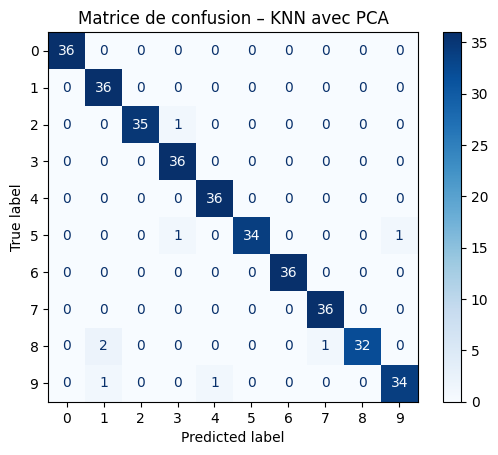

In [38]:
# Entraînement final du KNN avec le meilleur k
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_pca, y_train)

# Prédictions sur le jeu de test (après PCA)
y_test_final_pred = knn_final.predict(X_test_pca)
final_accuracy = accuracy_score(y_test, y_test_final_pred)

print("Accuracy finale sur le jeu de test reconstruit :", final_accuracy)

# Matrice de confusion
cm_pca = confusion_matrix(y_test, y_test_final_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_pca,
    display_labels=classes
)

plt.figure(figsize=(8,8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice de confusion – KNN avec PCA")
plt.show()


Remarque : On obtient la aussi un très bon score d'accuracy et une bonne matrice de confusion.

## Conclusion / Comparaison avec et sans PCA

In [39]:
# --- KNN sans PCA ---
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
start = time.time()
y_val_pred_knn = knn.predict(X_val)
end = time.time()
time_knn = end - start
acc_knn = accuracy_score(y_val, y_val_pred_knn)

# --- KNN avec PCA (reconstruction avec M composantes) ---
# Ici on projette X_val via PCA
start = time.time()
X_val_pca = pca_M.transform(X_val)
#start = time.time()
y_val_pred_knn_pca = knn_final.predict(X_val_pca)
end = time.time()
time_knn_pca = end - start
acc_knn_pca = accuracy_score(y_val, y_val_pred_knn_pca)

# --- Affichage des résultats ---
print("KNN sans PCA :")
print(f"  Accuracy sur validation : {acc_knn:.4f}")
print(f"  Temps d'inférence : {time_knn:.6f} s")

print("\nKNN avec PCA :")
print(f"  Accuracy sur validation : {acc_knn_pca:.4f}")
print(f"  Temps d'inférence : {time_knn_pca:.6f} s")


KNN sans PCA :
  Accuracy sur validation : 0.9861
  Temps d'inférence : 0.006101 s

KNN avec PCA :
  Accuracy sur validation : 0.9806
  Temps d'inférence : 0.002999 s


Avec cette comparaison on comfirme donc que l'on peut faire presque aussi bien mais avec un temps d'inférence bien plus rapide.